In [1]:
import pandas as pd
import numpy as np
import sys, os, re
import matplotlib.pyplot as plt

from importlib import reload

if re.match(r'^(\w\:\\)|(/)', os.getcwd()):
    # sys.path.insert(0, "c:/Users/dmitr/devs/quantl/")
    # sys.path.insert(0, "c:/Users/dmitr/devs/Qube/")
    sys.path.insert(0, "c:/Users/dmitr/devs/Qube2exp/src/")
    sys.path.insert(0, "c:/Users/dmitr/devs/Qube2exp/tests/")
    print('installed')

# import quantl.impl.indicators as Q

%load_ext cython

T = pd.date_range('2024-01-01 00:00', freq='1Min', periods=100_000)
ds = 1 + (2*np.random.randn(len(T))).cumsum()
data = list(zip(T, ds))

installed


## Helpers

In [2]:
import types
def apply_to_frame(func, x, *args, **kwargs):
    _keep_names = False
    if 'keep_names' in kwargs:
        _keep_names = kwargs.pop('keep_names')

    if func is None or not isinstance(func, types.FunctionType):
        raise ValueError(str(func) + ' must be callable object')

    xp = column_vector(func(x, *args, **kwargs))
    _name = None
    if not _keep_names:
        _name = func.__name__ + '_' + '_'.join([str(i) for i in args])

    if isinstance(x, pd.DataFrame):
        c_names = x.columns if _keep_names else ['%s_%s' % (c, _name) for c in x.columns]
        return pd.DataFrame(xp, index=x.index, columns=c_names)
    elif isinstance(x, pd.Series):
        return pd.Series(xp.flatten(), index=x.index, name=_name)

    return xp
def shift(xs: np.ndarray, n: int, fill=np.nan) -> np.ndarray:
    e = np.empty_like(xs)
    if n >= 0:
        e[:n] = fill
        e[n:] = xs[:-n]
    else:
        e[n:] = fill
        e[:n] = xs[-n:]
    return e

def nans(dims):
    return np.nan * np.ones(dims)

def column_vector(x):
    if isinstance(x, (pd.DataFrame, pd.Series)): x = x.values
    return np.reshape(x, (x.shape[0], -1))

def rolling_sum(x: np.ndarray, n: int) -> np.ndarray:
    for i in range(0, x.shape[1]):
        ret = np.nancumsum(x[:, i])
        ret[n:] = ret[n:] - ret[:-n]
        x[:, i] = np.concatenate((nans(n - 1), ret[n - 1:]))
    return x

def _calc_kama(x, period, fast_span, slow_span):
    x = x.astype(np.float64)
    for i in range(0, x.shape[1]):
        nan_start = np.where(~np.isnan(x[:, i]))[0][0]
        x_s = x[:, i][nan_start:]
        if period >= len(x_s):
            raise ValueError('Wrong value for period. period parameter must be less than number of input observations')
        abs_diff = np.abs(x_s - shift(x_s, 1))
        er = np.abs(x_s - shift(x_s, period)) / rolling_sum(np.reshape(abs_diff, (len(abs_diff), -1)), period)[:, 0]
        sc = np.square((er * (2.0 / (fast_span + 1) - 2.0 / (slow_span + 1.0)) + 2 / (slow_span + 1.0)))
        ama = nans(sc.shape)

        # here ama_0 = x_0
        ama[period - 1] = x_s[period - 1]
        for n in range(period, len(ama)):
            ama[n] = ama[n - 1] + sc[n] * (x_s[n] - ama[n - 1])

        # drop 1-st kama value (just for compatibility with ta-lib)
        ama[period - 1] = np.nan

        x[:, i] = np.concatenate((nans(nan_start), ama))

    return x

def kama(x, period, fast_span=2, slow_span=30):
    x = column_vector(x)
    return _calc_kama(x, period, fast_span, slow_span)

def kama_indicator(price, period=10, period_fast=2, period_slow=30):
    #Efficiency Ratio
    change = abs(price-price.shift(period))
    volatility = (abs(price-price.shift())).rolling(period).sum()
    er = change/volatility
    # return er

    #Smoothing Constant
    sc_fatest = 2/(period_fast + 1)
    sc_slowest = 2/(period_slow + 1)
    sc= (er * (sc_fatest - sc_slowest) + sc_slowest)**2
    # return sc

    #KAMA
    kama = np.zeros_like(price)
    kama[period-1] = price[period-1]
    for i in range(period, len(price)):
        kama[i] = kama[i-1] + sc[i] * (price[i] - kama[i-1])
    kama[kama==0]=np.nan

    return kama

## Cython v2 tests (cseries1)

In [48]:
%load_ext autoreload
%autoreload 2

from qube.utils import reload_pyx_module

reload_pyx_module('../../src/qube/core/')
from qube.core.series import TimeSeries
del sys.modules['qube.core.series']
from qube.core.series import (TimeSeries, Sma, Ema, recognize_time, Tema, Dema, Kama, OHLCV)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
 > Reloaded ../../src/qube/core\series.pyx


### Series Testing

In [4]:
# %%timeit
ts = TimeSeries('test', '10Min')
ts.update(recognize_time('2024-01-01 00:00'), 1)
ts.update(recognize_time('2024-01-01 00:01'), 5)
ts.update(recognize_time('2024-01-01 00:06'), 2)
ts.update(recognize_time('2024-01-01 00:12'), 3)
ts.update(recognize_time('2024-01-01 00:21'), 4)
ts.update(recognize_time('2024-01-01 00:22'), 5)
ts.update(recognize_time('2024-01-01 00:31'), 6)
ts.update(recognize_time('2024-01-01 00:33'), 7)
ts.update(recognize_time('2024-01-01 00:45'), -12)
ts.update(recognize_time('2024-01-01 00:55'), 12)
ts.update(recognize_time('2024-01-01 01:00'), 12)

1

In [5]:
ts.to_series().values

array([  2.,   3.,   5.,   7., -12.,  12.,  12.])

### <font color='orange'>WIP</font>

In [54]:
# %%timeit 
ts = TimeSeries('close', '1h')
s1 = Sma(ts, 50)
e1 = Ema(ts, 50)
ss1 = Sma(s1, 50)
ee1 = Ema(e1, 50)
t1 = Tema(ts, 50)
k1 = Kama(ts, 50)
[ts.update(ti.asm8, vi) for ti, vi in data];
k1s = k1.to_series().dropna()

In [55]:
# ik0 = apply_to_frame(kama, ts.to_series(), 50).dropna()
ik1 = apply_to_frame(kama_indicator, ts.to_series(), 50).dropna()
# ik1 - k1.to_series().dropna()
ik1

2024-01-03 01:00:00    -77.656493
2024-01-03 02:00:00    -77.498554
2024-01-03 03:00:00    -77.404650
2024-01-03 04:00:00    -77.490290
2024-01-03 05:00:00    -77.557940
                          ...    
2024-03-10 06:00:00    318.526099
2024-03-10 07:00:00    318.502677
2024-03-10 08:00:00    318.320884
2024-03-10 09:00:00    318.152174
2024-03-10 10:00:00    317.680129
Name: kama_indicator_50, Length: 1618, dtype: float64

In [57]:
k1 = Kama(ts, 50)
k1s = k1.to_series().dropna()

In [58]:
k1s

2024-01-03 01:00:00    -77.656493
2024-01-03 02:00:00    -77.498554
2024-01-03 03:00:00    -77.404650
2024-01-03 04:00:00    -77.490290
2024-01-03 05:00:00    -77.557940
                          ...    
2024-03-10 06:00:00    318.526099
2024-03-10 07:00:00    318.502677
2024-03-10 08:00:00    318.320884
2024-03-10 09:00:00    318.152174
2024-03-10 10:00:00    317.680129
Name: kama(50,2,30), Length: 1618, dtype: float64

In [ ]:
ik1 - k1s

In [ ]:
# ik1 = apply_to_frame(kama, ts.to_series(), 50)
# ik1.dropna()

In [ ]:
k1.to_series().dropna()

In [17]:
x0 = pd.Series(ds, T).resample('1H').last()
qt = Q.KAMA(50)
for t,v in zip(x0.index, x0.values):
    qt.update(v, t)

In [ ]:
plt.plot(ts.to_series(), lw=0.5)
plt.plot(k1.to_series())
plt.plot(pd.Series(qt.to_dict()['kama(50,2,30)']))

In [ ]:
plt.plot(ts.to_series(), lw=0.5)
plt.plot(Tema(ts, 50).to_series())
plt.plot(Dema(ts, 50).to_series())
plt.plot(t1.to_series())

In [9]:
# %%timeit
x0 = ts.to_series()
pe1 = x0.ewm(span=50, min_periods=50).mean()
pee1 = pe1.ewm(span=50, min_periods=50).mean()
ps1 = x0.rolling(50).mean()
pss1 = ps1.rolling(50).mean()

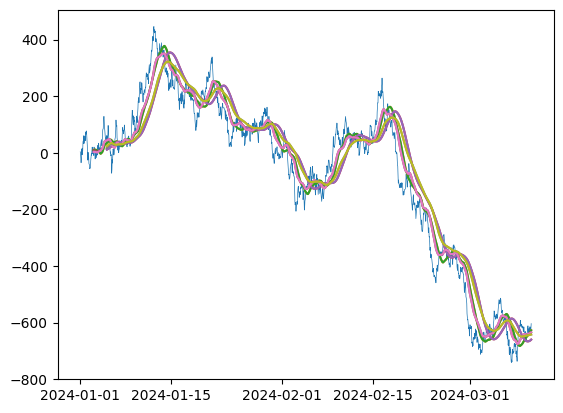

In [10]:
plt.plot(x0, lw=0.5)
plt.plot(s1.to_series()); plt.plot(ps1)
plt.plot(ss1.to_series()); plt.plot(pss1)
plt.plot(e1.to_series()); plt.plot(pe1)
plt.plot(ee1.to_series()); plt.plot(pee1)
# plt.plot(s1.to_series()-ps1)

In [13]:
# %%timeit
s1 = Sma(ts, 50)
e1 = Ema(ts, 50)
ss1 = Sma(s1, 50)
ee1 = Ema(e1, 50)
k1 = Kama(e1, 50)

In [ ]:
plt.plot(e1.to_series()); plt.plot(k1.to_series())

In [20]:
import types
def apply_to_frame(func, x, *args, **kwargs):
    _keep_names = False
    if 'keep_names' in kwargs:
        _keep_names = kwargs.pop('keep_names')

    if func is None or not isinstance(func, types.FunctionType):
        raise ValueError(str(func) + ' must be callable object')

    xp = column_vector(func(x, *args, **kwargs))
    _name = None
    if not _keep_names:
        _name = func.__name__ + '_' + '_'.join([str(i) for i in args])

    if isinstance(x, pd.DataFrame):
        c_names = x.columns if _keep_names else ['%s_%s' % (c, _name) for c in x.columns]
        return pd.DataFrame(xp, index=x.index, columns=c_names)
    elif isinstance(x, pd.Series):
        return pd.Series(xp.flatten(), index=x.index, name=_name)

    return xp
def shift(xs: np.ndarray, n: int, fill=np.nan) -> np.ndarray:
    e = np.empty_like(xs)
    if n >= 0:
        e[:n] = fill
        e[n:] = xs[:-n]
    else:
        e[n:] = fill
        e[:n] = xs[-n:]
    return e

def nans(dims):
    return np.nan * np.ones(dims)

def column_vector(x):
    if isinstance(x, (pd.DataFrame, pd.Series)): x = x.values
    return np.reshape(x, (x.shape[0], -1))

def rolling_sum(x: np.ndarray, n: int) -> np.ndarray:
    for i in range(0, x.shape[1]):
        ret = np.nancumsum(x[:, i])
        ret[n:] = ret[n:] - ret[:-n]
        x[:, i] = np.concatenate((nans(n - 1), ret[n - 1:]))
    return x

def _calc_kama(x, period, fast_span, slow_span):
    x = x.astype(np.float64)
    for i in range(0, x.shape[1]):
        nan_start = np.where(~np.isnan(x[:, i]))[0][0]
        x_s = x[:, i][nan_start:]
        if period >= len(x_s):
            raise ValueError('Wrong value for period. period parameter must be less than number of input observations')
        abs_diff = np.abs(x_s - shift(x_s, 1))
        er = np.abs(x_s - shift(x_s, period)) / rolling_sum(np.reshape(abs_diff, (len(abs_diff), -1)), period)[:, 0]
        sc = np.square((er * (2.0 / (fast_span + 1) - 2.0 / (slow_span + 1.0)) + 2 / (slow_span + 1.0)))
        ama = nans(sc.shape)

        # here ama_0 = x_0
        ama[period - 1] = x_s[period - 1]
        for n in range(period, len(ama)):
            ama[n] = ama[n - 1] + sc[n] * (x_s[n] - ama[n - 1])

        # drop 1-st kama value (just for compatibility with ta-lib)
        ama[period - 1] = np.nan

        x[:, i] = np.concatenate((nans(nan_start), ama))

    return x

def kama(x, period, fast_span=2, slow_span=30):
    x = column_vector(x)
    return _calc_kama(x, period, fast_span, slow_span)

### indicators work ... 

In [7]:
ts0 = TimeSeries('close', '1Min')
# em0 = Sma(ts0, 3)
# em1 = Sma(em0, 3)
k0 = Kama(ts0, 6)  

for t, v in [
    ('2024-01-01 00:00', 9), ('2024-01-01 00:00', 1),
    ('2024-01-01 00:01', 2), ('2024-01-01 00:01', 3),   ('2024-01-01 00:01', 2),
    ('2024-01-01 00:02', 3),
    ('2024-01-01 00:03', 4),
    ('2024-01-01 00:04', 5), ('2024-01-01 00:04', 5.1), ('2024-01-01 00:04:20', 5),
    ('2024-01-01 00:05', 6), ('2024-01-01 00:05', 7),   ('2024-01-01 00:05', 6),
    ('2024-01-01 00:07', 8), ('2024-01-01 00:07', -1),  ('2024-01-01 00:07', 8),
    ('2024-01-01 00:08', 8),
    ('2024-01-01 00:09', 8),
    ('2024-01-01 00:10', 12),
    ('2024-01-01 00:11', 13),
    ('2024-01-01 00:12', 14),
    ('2024-01-01 00:13', 15),
    ('2024-01-01 00:14', 17),
    ('2024-01-01 00:15', 4),
]:
    ts0.update(recognize_time(t), v)

In [8]:
k0.to_series()

2024-01-01 00:00:00          NaN
2024-01-01 00:01:00          NaN
2024-01-01 00:02:00          NaN
2024-01-01 00:03:00          NaN
2024-01-01 00:04:00          NaN
2024-01-01 00:05:00     6.000000
2024-01-01 00:07:00     6.674298
2024-01-01 00:08:00     7.099457
2024-01-01 00:09:00     7.368156
2024-01-01 00:10:00     8.988150
2024-01-01 00:11:00    10.391300
2024-01-01 00:12:00    11.352619
2024-01-01 00:13:00    12.973677
2024-01-01 00:14:00    14.763154
2024-01-01 00:15:00    13.898217
Name: kama(6,2,30), dtype: float64

### OHLC tests

In [9]:
ohlc = OHLCV('1Min')
s1 = Sma(ohlc.close, 5)
for t, v in [
    ('2024-01-01 00:00', 9), ('2024-01-01 00:00', 1),
    ('2024-01-01 00:01', 2), ('2024-01-01 00:01', 3),   ('2024-01-01 00:01', 2),
    ('2024-01-01 00:02', 3),
    ('2024-01-01 00:03', 4),
    ('2024-01-01 00:04', 5), ('2024-01-01 00:04', 5.1), ('2024-01-01 00:04:20', 5),
    ('2024-01-01 00:05', 6), ('2024-01-01 00:05', 7),   ('2024-01-01 00:05', 6),
    ('2024-01-01 00:07', 8), ('2024-01-01 00:07', -1),  ('2024-01-01 00:07', 8),
    ('2024-01-01 00:08', 8),
    ('2024-01-01 00:09', 8),
    ('2024-01-01 00:10', 12),('2024-01-01 00:10:01', 21),('2024-01-01 00:10:30', 1),('2024-01-01 00:10:31', 5),
    ('2024-01-01 00:11', 13),
    ('2024-01-01 00:12', 14),
    ('2024-01-01 00:13', 15),
    ('2024-01-01 00:14', 17),
    ('2024-01-01 00:15', 4),
]:
    ohlc.update(recognize_time(t), v, 1)

In [10]:
ohlc.to_series()

,open,high,low,close,volume
timestamp,,,,,
2024-01-01 00:00:00,9.0,9.0,1.0,1.0,2.0
2024-01-01 00:01:00,2.0,3.0,2.0,2.0,3.0
2024-01-01 00:02:00,3.0,3.0,3.0,3.0,1.0
2024-01-01 00:03:00,4.0,4.0,4.0,4.0,1.0
2024-01-01 00:04:00,5.0,5.1,5.0,5.0,3.0
2024-01-01 00:05:00,6.0,7.0,6.0,6.0,3.0
2024-01-01 00:07:00,8.0,8.0,-1.0,8.0,3.0
2024-01-01 00:08:00,8.0,8.0,8.0,8.0,1.0
2024-01-01 00:09:00,8.0,8.0,8.0,8.0,1.0


In [4]:
print(str(ohlc), str(s1))

OHLCV[1Min] | 15 records
  2024-01-01T00:15:00.000000000 {o:4.000000 | h:4.000000 | l:4.000000 | c:4.000000 | v:0.000000}
  2024-01-01T00:14:00.000000000 {o:17.000000 | h:17.000000 | l:17.000000 | c:17.000000 | v:0.000000}
  2024-01-01T00:13:00.000000000 {o:15.000000 | h:15.000000 | l:15.000000 | c:15.000000 | v:0.000000}
   .......... 
  2024-01-01T00:02:00.000000000 {o:3.000000 | h:3.000000 | l:3.000000 | c:3.000000 | v:0.000000}
  2024-01-01T00:01:00.000000000 {o:2.000000 | h:3.000000 | l:2.000000 | c:2.000000 | v:0.000000}
  2024-01-01T00:00:00.000000000 {o:9.000000 | h:9.000000 | l:1.000000 | c:1.000000 | v:0.000000}
 sma(5)[1Min] | 0 records



In [11]:
s1.to_series()

C:\Users\dmitr\AppData\Local\Temp\ipykernel_28024\2722279538.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s1.to_series()


Series([], Name: sma(5), dtype: float64)

In [5]:
ohlc[0]

{o:4.000000 | h:4.000000 | l:4.000000 | c:4.000000 | v:0.000000}

In [6]:
ohlc.to_series()

,open,high,low,close,volume
timestamp,,,,,
2024-01-01 00:00:00,9.0,9.0,1.0,1.0,0.0
2024-01-01 00:01:00,2.0,3.0,2.0,2.0,0.0
2024-01-01 00:02:00,3.0,3.0,3.0,3.0,0.0
2024-01-01 00:03:00,4.0,4.0,4.0,4.0,0.0
2024-01-01 00:04:00,5.0,5.1,5.0,5.0,0.0
2024-01-01 00:05:00,6.0,7.0,6.0,6.0,0.0
2024-01-01 00:07:00,8.0,8.0,-1.0,8.0,0.0
2024-01-01 00:08:00,8.0,8.0,8.0,8.0,0.0
2024-01-01 00:09:00,8.0,8.0,8.0,8.0,0.0


In [12]:
Sma(ohlc.close, 5).to_series()

2024-01-01 00:00:00     NaN
2024-01-01 00:01:00     NaN
2024-01-01 00:02:00     NaN
2024-01-01 00:03:00     NaN
2024-01-01 00:04:00     3.0
2024-01-01 00:05:00     4.0
2024-01-01 00:07:00     5.2
2024-01-01 00:08:00     6.2
2024-01-01 00:09:00     7.0
2024-01-01 00:10:00     7.0
2024-01-01 00:11:00     8.4
2024-01-01 00:12:00     9.6
2024-01-01 00:13:00    11.0
2024-01-01 00:14:00    12.8
2024-01-01 00:15:00    12.6
Name: sma(5), dtype: float64